# Tabular regressions
In this notebook we do regression and obtain conformal intervals of predictions for several tabular data sets.

### Download regression datasets from UCI
We create the infrastructure to download several regression data sets from [UCI](https://archive.ics.uci.edu/ml/datasets.php). Feel free to run this cell without looking into it, as it does not offer insights about Fortuna.

In [1]:
import abc
import logging
import os
import zipfile
from typing import Tuple
from urllib.request import urlopen

import numpy as np
import pandas as pd

from fortuna.data import DataLoader

_ALL_REGRESSION_DATASETS = {}


def add_regression(C):
    _ALL_REGRESSION_DATASETS.update({C.name: C})
    return C


class Dataset:
    def __init__(self, name: str, url: str, directory: str):
        self.name = name
        self.url = url
        self.directory = directory

    @property
    def datadir(self):
        return os.path.join(self.directory, self.name)

    @property
    def datapath(self):
        return os.path.join(self.datadir, self.url.split("/")[-1])

    @abc.abstractmethod
    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        pass

    def shuffle(self, X: np.array, Y: np.array, seed: int = 0):
        N = X.shape[0]
        perm = np.arange(N)
        np.random.seed(seed)
        np.random.shuffle(perm)
        return X[perm], Y[perm]

    def normalize(self, Z: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        Z_mean = np.mean(Z, 0, keepdims=True)
        Z_std = 1e-6 + np.std(Z, 0, keepdims=True)
        return (Z - Z_mean) / Z_std, Z_mean, Z_std

    def preprocess(self, X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        X, self.X_mean, self.X_std = self.normalize(X)
        Y, self.Y_mean, self.Y_std = self.normalize(Y)
        return X, Y

    def split(
        self,
        X: np.array,
        Y: np.array,
        prop_train: float = 0.8,
        prop_val: float = 0.1,
    ) -> Tuple[
        Tuple[np.ndarray, np.ndarray],
        Tuple[np.ndarray, np.ndarray],
        Tuple[np.ndarray, np.ndarray],
    ]:
        N = X.shape[0]
        n_train = int(N * prop_train)
        n_val = int(N * prop_val)
        train_data = X[:n_train], Y[:n_train]
        val_data = X[n_train : n_train + n_val], Y[n_train : n_train + n_val]
        test_data = X[n_train + n_val :], Y[n_train + n_val :]
        return train_data, val_data, test_data

    def batch(
        self,
        train_data: Tuple[np.ndarray, np.ndarray],
        val_data: Tuple[np.ndarray, np.ndarray],
        test_data: Tuple[np.ndarray, np.ndarray],
        batch_size: int = 128,
        shuffle_train: bool = False,
        prefetch: bool = True,
    ) -> Tuple[DataLoader, DataLoader, DataLoader]:
        train_data_loader = DataLoader.from_array_data(
            train_data, batch_size=batch_size, shuffle=shuffle_train, prefetch=prefetch
        )
        val_data_loader = DataLoader.from_array_data(
            val_data, batch_size=batch_size, prefetch=prefetch
        )
        test_data_loader = DataLoader.from_array_data(
            test_data, batch_size=batch_size, prefetch=prefetch
        )
        return train_data_loader, val_data_loader, test_data_loader

    def load(
        self,
        prop_train: float = 0.8,
        prop_val: float = 0.1,
        batch_size: int = 128,
        shuffle_train: bool = False,
        prefetch: bool = True,
    ) -> Tuple[DataLoader, DataLoader, DataLoader]:
        X, Y = self.read()
        X, Y = self.preprocess(X, Y)
        train_data, val_data, test_data = self.split(
            X, Y, prop_train=prop_train, prop_val=prop_val
        )
        return self.batch(
            train_data,
            val_data,
            test_data,
            batch_size=batch_size,
            shuffle_train=shuffle_train,
            prefetch=prefetch,
        )

    @property
    def needs_download(self):
        return not os.path.isfile(self.datapath)

    def download(self):
        if self.needs_download:
            logging.info("\nDownloading {} data...".format(self.name))

            if not os.path.isdir(self.datadir):
                os.mkdir(self.datadir)

            filename = os.path.join(self.datadir, self.url.split("/")[-1])
            with urlopen(self.url) as response, open(filename, "wb") as out_file:
                data = response.read()
                out_file.write(data)

            is_zipped = np.any([z in self.url for z in [".gz", ".zip", ".tar"]])
            if is_zipped:
                zip_ref = zipfile.ZipFile(filename, "r")
                zip_ref.extractall(self.datadir)
                zip_ref.close()

            logging.info("Download completed.".format(self.name))
        else:
            logging.info("{} dataset is already available.".format(self.name))


uci_base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/"


@add_regression
class Boston(Dataset):
    name = "boston"
    url = uci_base_url + "housing/housing.data"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_fwf(self.datapath, header=None).values
        return data[:, :-1], data[:, -1].reshape(-1, 1)


@add_regression
class Concrete(Dataset):
    name = "concrete"
    url = uci_base_url + "concrete/compressive/Concrete_Data.xls"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_excel(self.datapath).values
        return data[:, :-1], data[:, -1].reshape(-1, 1)


@add_regression
class Energy(Dataset):
    name = "energy"
    url = uci_base_url + "00242/ENB2012_data.xlsx"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_excel(self.datapath).values[:, :-1]
        return data[:, :-1], data[:, -1].reshape(-1, 1)


@add_regression
class Naval(Dataset):
    name = "naval"
    url = uci_base_url + "00316/UCI%20CBM%20Dataset.zip"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    @property
    def datapath(self):
        return os.path.join(self.datadir, "UCI CBM Dataset/data.txt")

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_fwf(self.datapath, header=None).values
        X = data[:, :-2]
        Y = data[:, -2].reshape(-1, 1)
        X = np.delete(X, [8, 11], axis=1)
        return X, Y


@add_regression
class Power(Dataset):
    name = "power"
    url = uci_base_url + "00294/CCPP.zip"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    @property
    def datapath(self):
        return os.path.join(self.datadir, "CCPP/Folds5x2_pp.xlsx")

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_excel(self.datapath).values
        return data[:, :-1], data[:, -1].reshape(-1, 1)


@add_regression
class Protein(Dataset):
    name = "protein"
    url = uci_base_url + "00265/CASP.csv"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_csv(self.datapath).values
        return data[:, 1:], data[:, 0].reshape(-1, 1)


@add_regression
class WineRed(Dataset):
    name = "winered"
    url = uci_base_url + "wine-quality/winequality-red.csv"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_csv(self.datapath, delimiter=";").values
        return data[:, :-1], data[:, -1].reshape(-1, 1)


@add_regression
class WineWhite(Dataset):
    name = "winewhite"
    url = uci_base_url + "wine-quality/winequality-white.csv"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_csv(self.datapath, delimiter=";").values
        return data[:, :-1], data[:, -1].reshape(-1, 1)


@add_regression
class Yacht(Dataset):
    name = "yacht"
    url = uci_base_url + "/00243/yacht_hydrodynamics.data"

    def __init__(self, directory, name=name, url=url):
        super().__init__(name=name, url=url, directory=directory)

    def read(self) -> Tuple[np.ndarray, np.ndarray]:
        data = pd.read_fwf(self.datapath, header=None).values[:-1, :]
        return data[:, :-1], data[:, -1].reshape(-1, 1)


regression_datasets = list(_ALL_REGRESSION_DATASETS.keys())
regression_datasets.sort()


def download_regression_dataset(name, directory, *args, **kwargs):
    dataset = _ALL_REGRESSION_DATASETS[name](directory, *args, **kwargs)
    dataset.download()


def download_all_regression_datasets(directory, *args, **kwargs):
    for name in list(_ALL_REGRESSION_DATASETS.keys()):
        download_regression_dataset(name, directory, *args, **kwargs)


def load_regression_dataset(
    name, dir, *args, **kwargs
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    dataset = _ALL_REGRESSION_DATASETS[name](dir)
    return dataset.load(*args, **kwargs)


download_all_regression_datasets(".")

### Regression on each data set
For each data set, we build a probabilistic regressor using MLP models for both mean and log-variance of the likelihood. We fit the posterior distribution with the default SWAG method, and calibrate the probabilistic model with a temperature scaling approach. Finally, compute 95% credible intervals and calibrate them with a quantile conformal method.

In [2]:
from fortuna.prob_model import ProbRegressor
from fortuna.prob_model.fit_config import FitConfig, FitMonitor, FitOptimizer
from fortuna.prob_model.calib_config import CalibConfig, CalibMonitor, CalibOptimizer
from fortuna.model import MLP
from fortuna.conformal.regression import QuantileConformalRegressor
from fortuna.metric.regression import rmse, picp
import optax
import tempfile

all_status = dict()
all_metrics = dict()

for dataset_name in regression_datasets:
    with tempfile.TemporaryDirectory() as data_dir:
        # download and load data
        download_regression_dataset(dataset_name, data_dir)
        train_data_loader, val_data_loader, test_data_loader = load_regression_dataset(
            dataset_name, data_dir, shuffle_train=True, batch_size=512
        )

        # find output dimension
        for batch_inputs, batch_targets in train_data_loader:
            output_dim = batch_targets.shape[-1]
            break

        # define probabilistic regressor
        prob_model = ProbRegressor(
            model=MLP(output_dim=output_dim),
            likelihood_log_variance_model=MLP(output_dim=output_dim),
        )

        # train the probabilistic regression
        all_status[dataset_name] = prob_model.train(
            train_data_loader=train_data_loader,
            val_data_loader=val_data_loader,
            calib_data_loader=val_data_loader,
            map_fit_config=FitConfig(
                monitor=FitMonitor(metrics=(rmse,), early_stopping_patience=2),
                optimizer=FitOptimizer(method=optax.adam(0.5 * 1e-1), n_epochs=300),
            ),
            fit_config=FitConfig(
                monitor=FitMonitor(metrics=(rmse,)),
                optimizer=FitOptimizer(method=optax.adam(0.2 * 1e-1), n_epochs=300),
            ),
            calib_config=CalibConfig(
                monitor=CalibMonitor(early_stopping_patience=2),
                optimizer=CalibOptimizer(n_epochs=300),
            )
        )

        # compute predictive statistics
        test_inputs_loader = test_data_loader.to_inputs_loader()
        test_means = prob_model.predictive.mean(inputs_loader=test_inputs_loader)
        test_cred_intervals = prob_model.predictive.credible_interval(
            inputs_loader=test_inputs_loader
        )

        # calibrate the credibility intervals
        val_inputs_loader = val_data_loader.to_inputs_loader()
        val_cred_intervals = prob_model.predictive.credible_interval(
            inputs_loader=val_inputs_loader
        )
        test_conformal_intervals = QuantileConformalRegressor().conformal_interval(
            val_lower_bounds=val_cred_intervals[:, 0],
            val_upper_bounds=val_cred_intervals[:, 1],
            test_lower_bounds=test_cred_intervals[:, 0],
            test_upper_bounds=test_cred_intervals[:, 1],
            val_targets=val_data_loader.to_array_targets(),
            error=0.05,
        )

        # compute metrics
        all_metrics[dataset_name] = dict()
        all_metrics[dataset_name]["picp"] = picp(
            lower_bounds=test_conformal_intervals[:, 0],
            upper_bounds=test_conformal_intervals[:, 1],
            targets=test_data_loader.to_array_targets(),
        )

Epoch: 12 | loss: 2893.25708 | rmse: 0.52322:   4%|███████▎                                                                                                                                                                                               | 11/300 [00:00<00:14, 20.38it/s]
Epoch: 300 | loss: 2512.47998 | rmse: 0.20301: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 219.28it/s]
Epoch: 50 | loss: 34.62534:  16%|███████████████████████████████████▎                                                                                                                                                                                    | 49/300 [00:00<00:01, 154.37it/s]
Epoch: 6 | loss: 3030.36548 | rmse: 0.54671:   2%|███▎                                                                                              

SWAG invokes a Maximum-A-Posteriori (MAP) estimation algorithm and starts from there to approximate the posterior distribution. The following cell shows the loss decay during MAP for each data set.

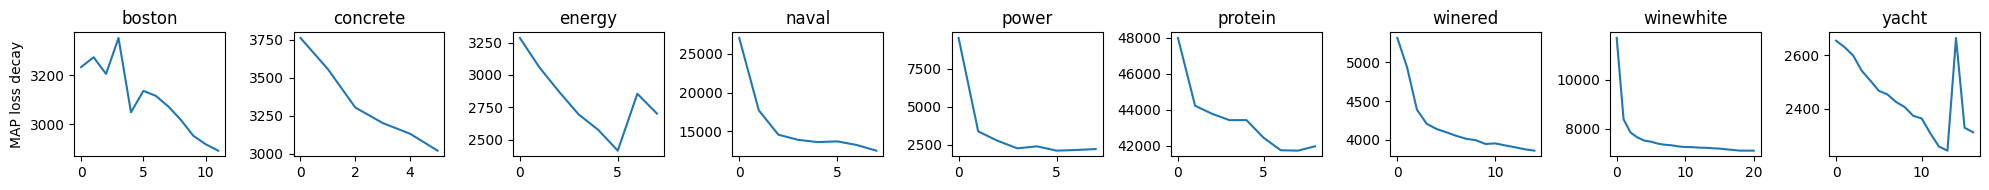

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(all_status), figsize=(20, 2))
for i, dataset_name in enumerate(all_status):
    axes[i].set_title(dataset_name)
    axes[0].set_ylabel("MAP loss decay")
    axes[i].plot(all_status[dataset_name]["fit_status"]["map"]["loss"])
plt.tight_layout()

We finally plot the Prediction Interval Coverage Probability (PICP) for each data set. Since the credible intervals are computed with a 95% coverage, we should expect PICPs to be as close as possible to 0.95.

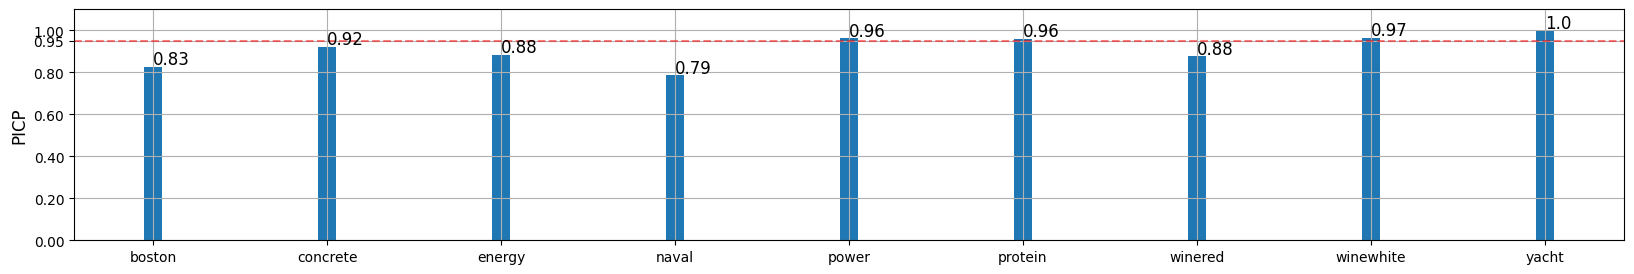

In [4]:
plt.figure(figsize=(20, 3))
plt.grid()
plt.axhline(0.95, color="red", alpha=0.5, linestyle="--")
plt.bar(
    regression_datasets,
    [all_metrics[dataset_name]["picp"] for dataset_name in all_metrics],
    width=0.1,
)
plt.ylabel("PICP", fontsize=12)
plt.yticks(list(plt.yticks()[0]) + [0.95])
plt.ylim([0, 1.1])
for dataset_name in regression_datasets:
    _picp = all_metrics[dataset_name]["picp"]
    plt.annotate(str(round(float(_picp), 2)), (dataset_name, _picp + 0.01), fontsize=12)